In [81]:
from torch import nn
import torch
import gymnasium as gym
import itertools
from collections import deque
import numpy as np
import random
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [82]:
GAMMA=0.99
BATCH_SIZE=32
BUFFER_SIZE=50000
MIN_REPLAY_SIZE=1000
EPSILON_START=1.0
EPSILON_END=0.02
EPSILON_DECAY=10000
TARGET_UPDATE_FREQ=1000
LEARNING_RATE=5e-4
EPISODES = 210

In [83]:
class Network(nn.Module):
    def __init__(self, env) -> None:
        super().__init__()
        in_features = int(np.prod(env.observation_space.shape))

        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, env.action_space.n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def act(self, obs, device):
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device)
        q_values = self(obs_t.unsqueeze(0)) # Unsqueezing to bring batch dimension as forward pass expects it

        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()

        return action



In [84]:
def plot_durations(show_result=False, episode_durations=[]):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [85]:
env = gym.make('CartPole-v1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

replay_buffer = deque(maxlen=BUFFER_SIZE)
episode_rewards = []

In [86]:
# Initialization and filling replay buffer
online_net = Network(env).to(device)
target_net = Network(env).to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.Adam(online_net.parameters(), lr=LEARNING_RATE)
#schedular = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10000, gamma=0.7)

obs, info = env.reset()
for _ in range(MIN_REPLAY_SIZE):
    action = env.action_space.sample()

    new_obs, rew, terminated, truncated, info = env.step(action)
    transition = (obs, action, rew, terminated, new_obs)
    replay_buffer.append(transition)
    obs = new_obs

    if truncated or terminated:
        obs, info = env.reset()


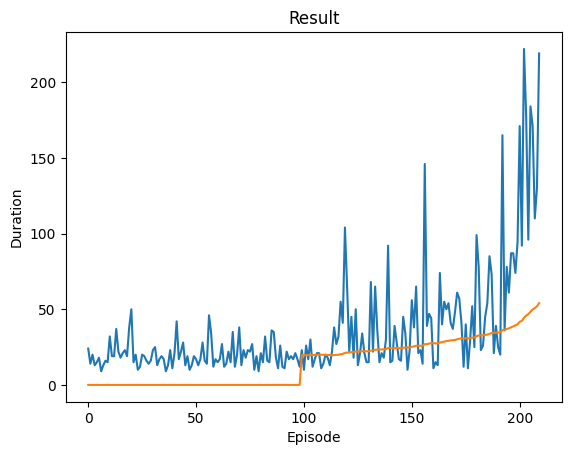

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [87]:
# Main training loop
obs, info = env.reset()
episode_reward = 0.0

for step in itertools.count():
    epsilon = np.interp(step, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])
    rand_sample = random.random()

    if rand_sample <= epsilon:
        action = env.action_space.sample()
    else:
        online_net.eval()
        action = online_net.act(obs=obs, device=device)

    new_obs, rew, terminated, truncated, info = env.step(action)
    transition = (obs, action, rew, terminated, new_obs)
    replay_buffer.append(transition)
    obs = new_obs

    episode_reward += rew

    if truncated or terminated:
        obs, info = env.reset()
        episode_rewards.append(episode_reward)
        plot_durations(show_result=False, episode_durations=episode_rewards)
        episode_reward = 0.0

    
    # Start Gradient step
    transitions = random.sample(replay_buffer, BATCH_SIZE)

    obses = np.asarray([t[0] for t in transitions])
    actions = np.asarray([t[1] for t in transitions])
    rewards = np.asarray([t[2] for t in transitions])
    terminated = np.asarray([t[3] for t in transitions])
    new_obses = np.asarray([t[4] for t in transitions])

    obses_t = torch.as_tensor(obses, dtype=torch.float32, device=device)
    actions_t = torch.as_tensor(actions, dtype=torch.int64, device=device).unsqueeze(-1)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32, device=device).unsqueeze(-1)
    terminated_t = torch.as_tensor(terminated, dtype=torch.float32, device=device).unsqueeze(-1)
    new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32, device=device)

    # Compute Targets
    target_q_values = target_net(new_obses_t)
    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
    
    targets = rewards_t + GAMMA * (1 - terminated_t) * max_target_q_values

    # Compute Loss
    online_net.train()
    q_values = online_net(obses_t)
    action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

    loss = F.smooth_l1_loss(action_q_values, targets)
    # After solved, watch it play
    """if len(episode_rewards) >= 100 and np.mean(episode_rewards[:-100]) >= 300:
        env.close()
        env = gym.make('CartPole-v1', render_mode="human")
        while(True):
            action = online_net.act(obs, device=device)
            obs, _, done, _, _ = env.step(action)
            if done:
                env.reset()"""


    # Gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #schedular.step()

    # Update target network
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.load_state_dict(online_net.state_dict())

    if len(episode_rewards) >= EPISODES:
        plot_durations(show_result=True, episode_durations=episode_rewards)
        break


In [88]:
env = gym.make('CartPole-v1', render_mode='human')
online_net.eval()

obs, info = env.reset()
for _ in range(MIN_REPLAY_SIZE):
    action = online_net.act(obs=obs, device=device)

    new_obs, rew, terminated, truncated, info = env.step(action)
    obs = new_obs

    if truncated or terminated:
        obs, info = env.reset()

In [ ]:
env.close()